## Librerías

In [1]:
# Libraries which will help us to manipulate a lil bit more our data
import numpy as np
import pandas as pd

# pandas: display all columns
pd.set_option('display.max_columns', None)

# Sklearn: Library for Train/Test Split // confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# TensorFlow: Library for model training
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Matplotlib: Library for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Functions: Library which contains all the functions that we'll use
import functions as fn

# Functions: Library which contains all the visualizations that we'll plot
import visualizations as vz

# Display plotly graphs in HTML
import plotly.io as pio
pio.renderers.default='notebook'

from collections import Counter

from CDIN import CDIN as eda

## Cargar datos

In [2]:
data= pd.read_parquet('Data_new_outliers.parquet')
data.drop(columns=["", "fraccion4", "Precio_raro", "articulo", "pais_origen_destino", "descripcion limpia", "descripcion", 
                   "TIGIE_D", "unidad_medida", "descripcion_unidad_medida", "codigo_pais", "continente"], inplace = True)

# Guardar en una variable el nombre de nuestra variable objetivo
target_variable ='outlier'

In [3]:
# Aplicar label encoder para castear texto a numérico
data = fn.label_encoder(data)

In [4]:
Counter(data["outlier"])

Counter({0: 887167, 1: 39122})

In [5]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

# Weights

In [33]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
test_df_for_heatmap = test_df.copy()
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [7]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop(target_variable))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(target_variable))
test_labels = np.array(test_df.pop(target_variable))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)
test_features_for_heatmap = test_features.copy()

$$w_j = \frac{n}{kn_j}$$

$\text{Where}$ \
$w_j: \ \text{is the weight to class j}$ \
$n: \ \text{is the number of observations}$ \
$n_j: \ \text{is the number of observations in class j, and}$ \
$k: \ \text{is the total number of classes.}$


In [9]:
unique_classes = [0, 1]

In [10]:
class_weight  = {}
for classes in unique_classes:
    class_weight[classes] = data.shape[0]/((data.loc[data[target_variable] == classes].shape[0])*len(unique_classes))

In [11]:
class_weight

{0: 0.5220488363521186, 1: 11.838466847298195}

In [12]:
EPOCHS = 10
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
weighted_model = make_model()

In [14]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/10
290/290 [==============================] - 8s 14ms/step - loss: 0.6551 - accuracy: 0.7040 - precision: 0.0696 - recall: 0.4883 - auc: 0.6623 - val_loss: 0.5375 - val_accuracy: 0.8038 - val_precision: 0.1333 - val_recall: 0.6514 - val_auc: 0.8119
Epoch 2/10
290/290 [==============================] - 2s 7ms/step - loss: 0.5475 - accuracy: 0.7751 - precision: 0.1154 - recall: 0.6526 - auc: 0.7989 - val_loss: 0.4587 - val_accuracy: 0.8559 - val_precision: 0.1848 - val_recall: 0.6932 - val_auc: 0.8758
Epoch 3/10
290/290 [==============================] - 2s 7ms/step - loss: 0.4796 - accuracy: 0.8340 - precision: 0.1624 - recall: 0.7096 - auc: 0.8590 - val_loss: 0.4151 - val_accuracy: 0.8797 - val_precision: 0.2245 - val_recall: 0.7375 - val_auc: 0.9068
Epoch 4/10
290/290 [==============================] - 2s 8ms/step - loss: 0.4448 - accuracy: 0.8481 - precision: 0.1827 - recall: 0.7529 - auc: 0.8850 - val_loss: 0.3909 - val_accuracy: 0.8789 - val_precision: 0.2279 - val_recall: 

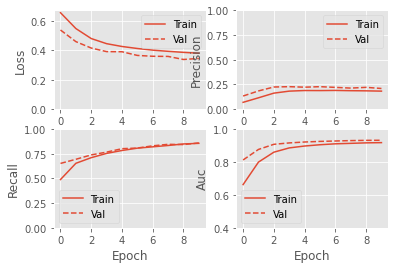

In [15]:
vz.plot_wmetrics(weighted_history)

In [16]:
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

91/91 [==============================] - 1s 5ms/step


In [17]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate No-Outliers Detected (True Negatives): ', cm[0][0])
    print('Legitimate No-Outliers Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Outliers Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Outliers Detected (True Positives): ', cm[1][1])
    print('Total Outliers: ', np.sum(cm[1]))
    print('Total No-Outliers: ', np.sum(cm[0]))

Legitimate No-Outliers Detected (True Negatives):  151935
Legitimate No-Outliers Incorrectly Detected (False Positives):  25462
Fraudulent Outliers Missed (False Negatives):  1181
Fraudulent Outliers Detected (True Positives):  6680
Total Outliers:  7861
Total No-Outliers:  177397


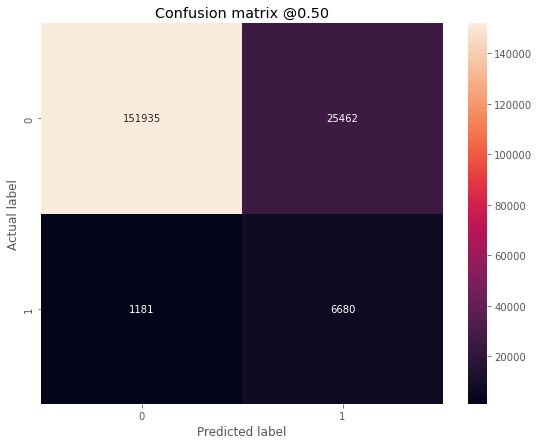

In [18]:
plot_cm(test_labels, test_predictions_weighted)

In [19]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', np.round(value, 2))

f1 = (2*weighted_results[2]*weighted_results[3])/(weighted_results[2]+weighted_results[3])
print("f1 : ", np.round(f1, 2))

loss :  0.34
accuracy :  0.86
precision :  0.21
recall :  0.85
auc :  0.93
f1 :  0.33


# Decile Analysis

In [20]:
decile_analysis = fn.decile_analysis(test_predictions_weighted, test_labels)
decile_analysis

,Batch,Cumulative Batch,Cumulative % Batch,True label,True label %,Cumulative label %,Probability Range
Decile,,,,,,,
1,18526,18526,0.1,5705,0.7257,0.7257,1.0 - 0.662
2,18526,37052,0.2,1168,0.1486,0.8743,0.662 - 0.4459
3,18526,55578,0.3,551,0.0701,0.9444,0.4459 - 0.2913
4,18526,74104,0.4,190,0.0242,0.9686,0.2913 - 0.1958
5,18526,92630,0.5,105,0.0134,0.9819,0.1958 - 0.1359
6,18526,111156,0.6,58,0.0074,0.9893,0.1358 - 0.0959
7,18526,129682,0.7,47,0.0060,0.9953,0.0959 - 0.0683
8,18526,148208,0.8,4,0.0005,0.9958,0.0683 - 0.0496
9,18525,166733,0.9,3,0.0004,0.9962,0.0496 - 0.032


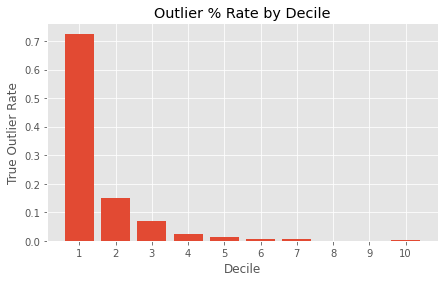

In [21]:
vz.decile_analysis_plot(decile_analysis["True label %"])

In [22]:
test_predictions_weighted = test_predictions_weighted.ravel()
test_predictions_weighted

array([0.24936655, 0.36851797, 0.0638582 , ..., 0.05661025, 0.10962718,
       0.09051383], dtype=float32)

In [23]:
x = pd.qcut(test_predictions_weighted, 10)
x

[(0.196, 0.291], (0.291, 0.446], (0.0496, 0.0683], (0.032, 0.0496], (0.032, 0.0496], ..., (0.0683, 0.0959], (0.0959, 0.136], (0.0496, 0.0683], (0.0959, 0.136], (0.0683, 0.0959]]
Length: 185258
Categories (10, interval[float64, right]): [(-0.001, 0.032] < (0.032, 0.0496] < (0.0496, 0.0683] < (0.0683, 0.0959] ... (0.196, 0.291] < (0.291, 0.446] < (0.446, 0.662] < (0.662, 1.0]]

In [43]:
test_df_for_heatmap

,clave_aduana,fraccion,precio_unitario,cantidad_mercancia,clave_tarifa,tipo_cambio,total_fletes,total_seguros,total_embalajes,total_incrementales,total_deducibles,month,year,first word,Impuestos,pais,poliester,algodon,viscosa,rayon,acrilico,lino,lana,poliamida,elastano,poliuretano,otro,outlier
114162,70,59032001,179.13138,94.841,4,18.5715,0,0,0,0,0,2,2020,4578,0.10,96,0,0,0,0,0,0,0,0,0,0,0,0
161598,240,61099091,100.00000,1.000,6,19.7760,4746,0,0,494,0,3,2020,1374,0.25,108,0,0,0,0,0,0,0,0,0,0,0,0
407346,470,62029391,559.28571,7.000,6,20.1858,0,0,0,0,0,11,2020,1505,0.25,34,0,0,0,0,0,0,0,0,0,0,0,0
746653,470,62046209,194.49242,132.000,6,19.9487,0,0,0,0,0,5,2021,3595,0.00,13,0,0,0,0,0,0,0,0,0,0,0,0
70910,270,62114399,128.00000,1.000,6,18.7007,0,0,0,0,0,1,2020,913,0.20,28,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264548,160,61121201,44.77574,20160.000,6,22.6140,0,0,0,0,0,8,2020,1590,0.25,34,0,0,0,0,0,0,0,0,0,0,0,0
337758,510,62045391,106.30952,84.000,6,22.3678,40016,117,0,12898,0,10,2020,2384,0.25,34,0,0,0,0,0,0,0,0,0,0,0,0
23114,240,61046291,128.10000,10.000,6,18.6883,4077,0,0,467,0,1,2020,3595,0.00,157,0,0,0,0,0,0,0,0,0,0,0,0
817861,240,61112012,263.00000,1.000,6,20.1348,5537,0,0,2517,0,7,2021,3939,0.00,34,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
z = pd.DataFrame(
    data = {
        "interval": x,
        "prob": test_predictions_weighted
    }
).sort_values(by = "prob")[::-1]
z.reset_index(inplace=True)
z.drop(columns=["index"], inplace=True)

In [36]:
z["interval"] = z["interval"].astype(str)

In [37]:
# test_df
# test_df.reset_index(inplace=True)
# test_df.drop(columns=["index"], inplace=True)

In [38]:
z = z.join(pd.DataFrame(test_df_for_heatmap))

In [39]:
zdict = sorted(list(set(z["interval"])))
xaa = {k:v for k,v in zip(zdict,np.arange(1,11,1))}
xaa

{'(-0.001, 0.032]': 1,
 '(0.032, 0.0496]': 2,
 '(0.0496, 0.0683]': 3,
 '(0.0683, 0.0959]': 4,
 '(0.0959, 0.136]': 5,
 '(0.136, 0.196]': 6,
 '(0.196, 0.291]': 7,
 '(0.291, 0.446]': 8,
 '(0.446, 0.662]': 9,
 '(0.662, 1.0]': 10}

In [40]:
z["decile"] = z["interval"].map(xaa)

In [49]:
zgby = z.groupby(by=["decile"]).mean()

In [63]:
grouped = np.round(zgby,2).iloc[:,:17]
grouped

,prob,clave_aduana,fraccion,precio_unitario,cantidad_mercancia,clave_tarifa,tipo_cambio,total_fletes,total_seguros,total_embalajes,total_incrementales,total_deducibles,month,year,first word,Impuestos,pais
decile,,,,,,,,,,,,,,,,,
1,0.02,325.77,60263099.28,455.09,7966.98,4.68,23.23,24307.84,399.77,31.50,9813.76,0.00,3.46,2020.0,2806.55,0.16,85.66
2,0.04,299.69,61186063.00,231.31,2880.11,5.63,19.79,10049.05,114.52,4.26,1848.99,0.00,3.00,2020.0,2612.00,0.19,88.01
3,0.06,318.26,60793743.74,324.60,3365.51,5.29,18.96,36752.07,538.77,41.62,4538.37,0.00,2.34,2020.0,2712.11,0.18,86.07
4,0.08,328.38,61151557.93,195.93,1503.29,5.63,18.80,12263.18,352.63,8.94,3004.13,0.00,2.00,2020.0,2601.70,0.19,84.28
5,0.11,310.59,61058766.41,226.97,3326.67,5.57,18.76,11334.77,131.85,11.10,2127.25,0.00,2.00,2020.0,2685.60,0.19,85.47
6,0.16,306.30,60989976.40,235.95,2152.22,5.52,18.76,12598.36,276.63,10.88,2563.65,136.40,1.38,2020.0,2732.24,0.18,88.66
7,0.24,313.68,61051421.54,208.20,2392.64,5.52,18.78,11013.56,199.63,189.13,2758.43,269.85,1.00,2020.0,2795.15,0.18,85.30
8,0.36,320.84,60855191.65,253.61,5043.15,5.31,18.79,9642.47,320.68,5.07,3140.02,0.00,1.00,2020.0,2698.02,0.18,86.20
9,0.55,325.69,61100131.85,205.88,1237.15,5.58,18.78,12457.05,217.26,14.17,4465.88,0.00,1.00,2020.0,2770.33,0.18,84.29


In [65]:
for col in grouped.columns:
    if col != 'prob':
        grouped[col] = (grouped[col]) / grouped[col].max()

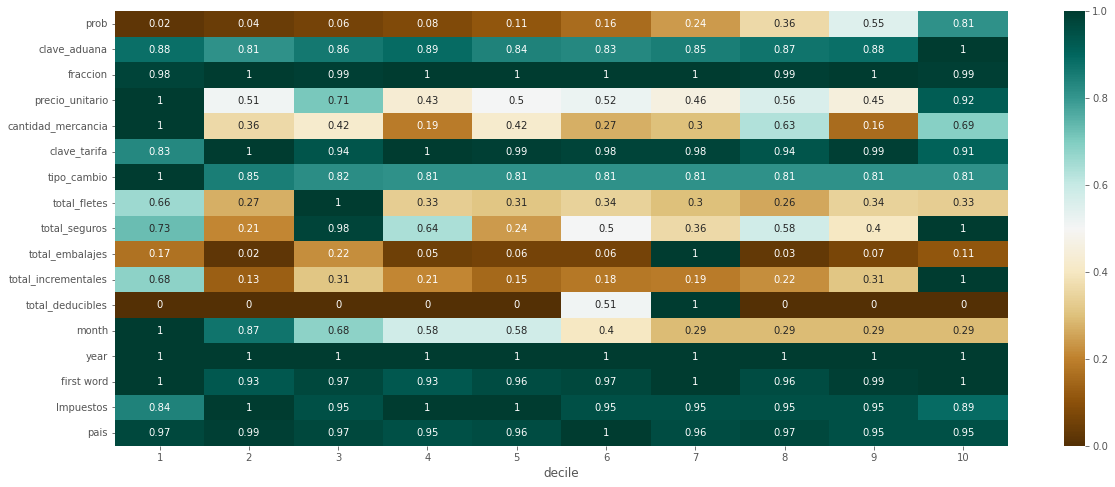

In [67]:
plt.figure(figsize=(20, 8))
sns.heatmap(np.round(np.round(grouped,2).iloc[:,:17].T,2), vmin=0, vmax=1,annot=True, cmap='BrBG');